![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 8 - CNN Architectures</center>
### <center> ResNet </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/MainResNet.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/08_CnnArchitectures/DeepLearningFramework ./DeepLearningFramework
    !pip install torchinfo

In [4]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn               as nn
import torch.optim            as optim
import torchvision
import torchvision.transforms as transforms
import torchinfo

In [5]:
from DeepLearningFramework.Training import TrainClassficationModel

### Download CIFAR-10 dataset:

In [6]:
DATA_PATH = '../../data'
oTrainSet = torchvision.datasets.CIFAR10(root=DATA_PATH, train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

oTrainSet.data.shape, oTrainSet[0][0].shape

Files already downloaded and verified
Files already downloaded and verified


((50000, 32, 32, 3), torch.Size([3, 32, 32]))

In [7]:
lClasses  = oTrainSet.classes
lClasses

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Plot some examples:

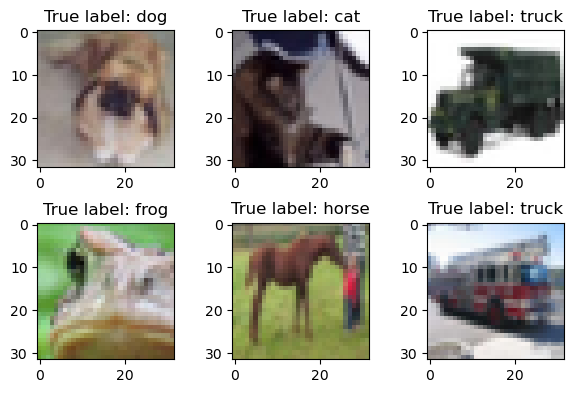

In [8]:
N, H, W, C = oTrainSet.data.shape
fig, _     = plt.subplots(2, 3, figsize=(6, 4))
for ax in fig.axes:
    idx   = np.random.randint(0, N)
    mX, y = oTrainSet[idx]
    ax.imshow   (np.transpose(mX.numpy(), (1,2,0)))
    ax.set_title(f'True label: {lClasses[y]}')
    
plt.tight_layout()
plt.show()

#### Compute mean and variance:

In [9]:
vMean = oTrainSet.data.mean((0,1,2)) / 255
vStd  = oTrainSet.data.std ((0,1,2)) / 255
print('µ =', vMean)
print('σ =', vStd)

µ = [0.49139968 0.48215841 0.44653091]
σ = [0.24703223 0.24348513 0.26158784]


#### Set datasets with normalization:

In [10]:
oTransform = transforms.Compose([
    transforms.ToTensor (),
    transforms.Normalize(vMean, vStd)
])

oTrainSet.transform = oTransform
oTestSet .transform = oTransform

#### Create data loaders:

In [11]:
batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX, vY    = next(iter(oTrainDL))
mX.shape

torch.Size([128, 3, 32, 32])

#### Define the model (ResNet):
<img src='https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/08_CnnArchitectures/ResBlock.png?raw=true' alt="Drawing" style="width: 150px;"/>

In [12]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        self.oLeft = nn.Sequential(
            nn.Conv2d(C, C, 3, padding=1, bias=False), nn.BatchNorm2d(C), nn.ReLU(),
            nn.Conv2d(C, C, 3, padding=1, bias=False), nn.BatchNorm2d(C),
        )
        

    def forward(self, mX):
        mZ = torch.relu(self.oLeft(mX) + mX)
        return mZ
        
torchinfo.summary(ResBlock(64), (4, 64, 56, 56))

Layer (type:depth-idx)                   Output Shape              Param #
ResBlock                                 --                        --
├─Sequential: 1-1                        [4, 64, 56, 56]           --
│    └─Conv2d: 2-1                       [4, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-2                  [4, 64, 56, 56]           128
│    └─ReLU: 2-3                         [4, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [4, 64, 56, 56]           36,864
│    └─BatchNorm2d: 2-5                  [4, 64, 56, 56]           128
Total params: 73,984
Trainable params: 73,984
Non-trainable params: 0
Total mult-adds (M): 924.85
Input size (MB): 3.21
Forward/backward pass size (MB): 25.69
Params size (MB): 0.30
Estimated Total Size (MB): 29.20

In [16]:
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def InitWeights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data)
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
def GetModel():
    d      = 128
    oModel = nn.Sequential(
        nn.Identity(),
        nn.Conv2d(3, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),                   nn.Dropout2d(0.2),
        nn.Conv2d(d, d, 3, padding=1, bias=False), nn.BatchNorm2d(d),  nn.ReLU(),  nn.MaxPool2d(2), nn.Dropout2d(0.2),
        
        ResBlock (d), nn.Dropout2d(0.2),
        ResBlock (d), nn.Dropout2d(0.2),
        
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten          (),
        nn.Linear           (d, 10)
    )
    
    oModel.apply(InitWeights)
    
    return oModel
#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
torchinfo.summary(GetModel(), mX.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Identity: 1-1                          [128, 3, 32, 32]          --
├─Conv2d: 1-2                            [128, 128, 32, 32]        3,456
├─BatchNorm2d: 1-3                       [128, 128, 32, 32]        256
├─ReLU: 1-4                              [128, 128, 32, 32]        --
├─Dropout2d: 1-5                         [128, 128, 32, 32]        --
├─Conv2d: 1-6                            [128, 128, 32, 32]        147,456
├─BatchNorm2d: 1-7                       [128, 128, 32, 32]        256
├─ReLU: 1-8                              [128, 128, 32, 32]        --
├─MaxPool2d: 1-9                         [128, 128, 16, 16]        --
├─Dropout2d: 1-10                        [128, 128, 16, 16]        --
├─ResBlock: 1-11                         [128, 128, 16, 16]        --
│    └─Sequential: 2-1                   [128, 128, 16, 16]        --
│    

In [17]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.CrossEntropyLoss()

In [18]:
from torch.optim.lr_scheduler import OneCycleLR

nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)

oModel        = GetModel               ().to(DEVICE)
oOptim        = optim.AdamW            (oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=2e-2)
oScheduler    = OneCycleLR             (oOptim, max_lr=1e-2, total_steps=nIter)
lHistory      = TrainClassficationModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler)

Epoch 000: | Train loss:  1.808 | Val loss:  1.455 | Train Accuracy:  0.325 | Val Accuracy:  0.482 | epoch time: 31.154 | <-- Checkpoint!
Epoch 001: | Train loss:  1.473 | Val loss:  1.241 | Train Accuracy:  0.458 | Val Accuracy:  0.559 | epoch time: 27.861 | <-- Checkpoint!
Epoch 002: | Train loss:  1.277 | Val loss:  1.063 | Train Accuracy:  0.535 | Val Accuracy:  0.624 | epoch time: 27.510 | <-- Checkpoint!
Epoch 003: | Train loss:  1.120 | Val loss:  0.945 | Train Accuracy:  0.598 | Val Accuracy:  0.664 | epoch time: 27.947 | <-- Checkpoint!
Epoch 004: | Train loss:  1.005 | Val loss:  0.876 | Train Accuracy:  0.640 | Val Accuracy:  0.692 | epoch time: 28.308 | <-- Checkpoint!
Epoch 005: | Train loss:  0.905 | Val loss:  0.839 | Train Accuracy:  0.679 | Val Accuracy:  0.705 | epoch time: 28.121 | <-- Checkpoint!
Epoch 006: | Train loss:  0.828 | Val loss:  0.709 | Train Accuracy:  0.714 | Val Accuracy:  0.754 | epoch time: 27.778 | <-- Checkpoint!
Epoch 007: | Train loss:  0.767 | 

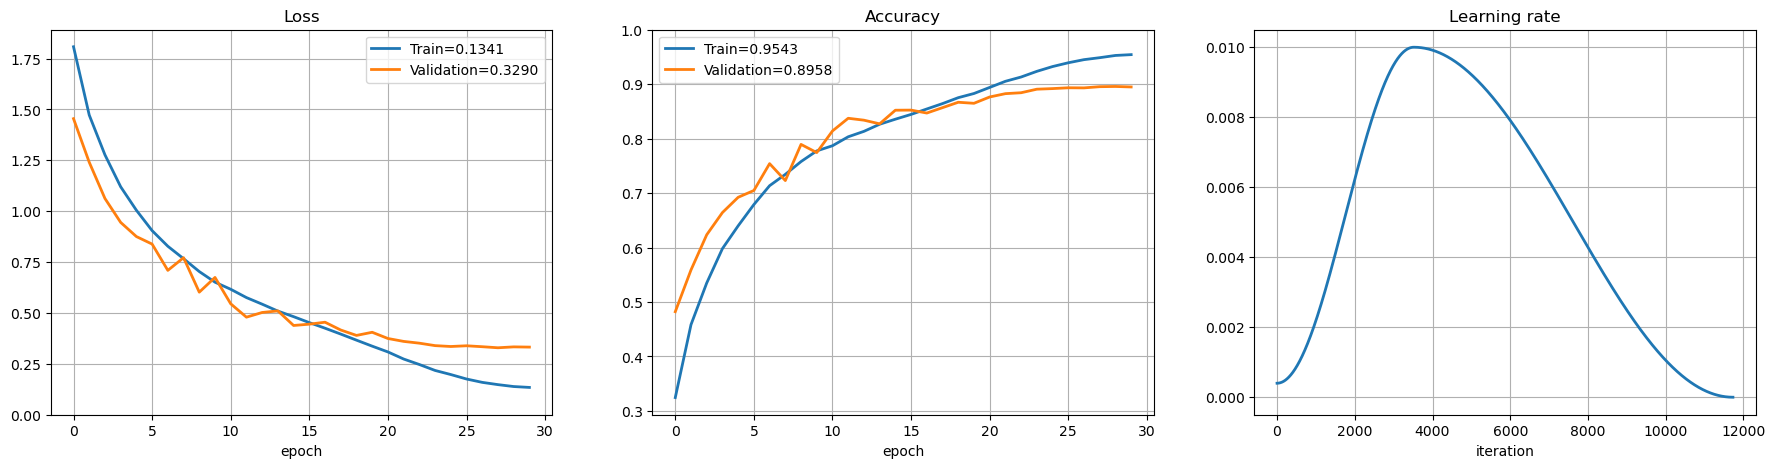

In [22]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

#### How to improve:
* Hyper-parameters:
    * Learning rate
* Regularization:
    * Weight decay
    * Dropout
* More layers